# 04 — Model training and evaluation on ESM-1b embeddings

In this notebook we build and evaluate machine learning models on top of the
precomputed **ESM-1b embeddings** of protein sequences.

We use the artifacts produced in `03_esm_embeddings.ipynb`:

- Embeddings:  
  `artifacts/embeddings/esm1b_embeddings_small_maxlen1000.npy`
- Metadata (targets & info):  
  `artifacts/embeddings/metadata_small_maxlen1000.csv`

### Goals of this notebook

1. **Prepare data for modeling**
   - Load embeddings and metadata.
   - Encode protein families as integer labels.
   - Split data into **train / validation / test** sets with stratification.

2. **Train baseline and stronger classifiers**
   - Baseline: **Multinomial Logistic Regression** on top of ESM embeddings.
   - Tree-based / boosted model: **CatBoostClassifier** (using GPU/CPU, if available).
   - (Optional) simple **MLP** as a neural baseline.

3. **Evaluate model quality**
   - Metrics:
     - accuracy,
     - macro F1-score,
   - Per-class performance:
     - classification report,
     - confusion matrix.

4. **Track experiments with MLflow**
   - Log:
     - model type & key hyperparameters,
     - validation and test metrics,
     - confusion matrix figure as an artifact.
   - Use a dedicated MLflow experiment for this project.

### Output of this notebook

By the end of this notebook we obtain:

- Trained baseline and boosted models for protein family classification.
- Quantitative evaluation on a held-out test set.
- MLflow runs with logged parameters, metrics and plots.

These trained models and their metrics will be used in:

- `05_interpret_and_visualize.ipynb` —  
  where we focus on UMAP projections, SHAP-based interpretation and
  per-protein case studies (including 3D visualization for selected examples).


In [3]:
# Cell 1: базовые импорты и настройка путей + MLflow

from pathlib import Path
import sys
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import mlflow
import mlflow.sklearn
from joblib import dump
import warning
%matplotlib inline

# Настройка путей проекта
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import EMB_DIR  

# Директории артефактов
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
MODELS_DIR = ARTIFACTS_DIR / "models"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
LOGS_DIR = PROJECT_ROOT / "logs"

for d in [MODELS_DIR, FIGURES_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Настройка MLflow 

# Директория для tracking-хранилища
MLFLOW_TRACKING_DIR = LOGS_DIR / "mlruns"
MLFLOW_TRACKING_DIR.mkdir(parents=True, exist_ok=True)

# Превращаем путь в корректный file:// URI,
# чтобы не было схемы "d" на Windows
MLFLOW_TRACKING_URI = MLFLOW_TRACKING_DIR.as_uri()  # типа file:///D:/ML/...

# На всякий случай отключим отдельный registry URI,
# чтобы он не пытался использовать тот же "сырой" путь
os.environ["MLFLOW_REGISTRY_URI"] = ""

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

BASELINE_EXPERIMENT_NAME = "esm_protein_family_baselines"
mlflow.set_experiment(BASELINE_EXPERIMENT_NAME)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("Embeddings dir:", EMB_DIR)
print("MLflow tracking URI:", MLFLOW_TRACKING_URI)
print("Experiment:", BASELINE_EXPERIMENT_NAME)
print("Models dir:", MODELS_DIR)
print("Figures dir:", FIGURES_DIR)
print("Logs dir:", LOGS_DIR)

2025/12/06 12:23:46 INFO mlflow.tracking.fluent: Experiment with name 'esm_protein_family_baselines' does not exist. Creating a new experiment.


PROJECT_ROOT: D:\ML\BioML\ESM
Embeddings dir: D:\ML\BioML\ESM\artifacts\embeddings
MLflow tracking URI: file:///D:/ML/BioML/ESM/logs/mlruns
Experiment: esm_protein_family_baselines
Models dir: D:\ML\BioML\ESM\artifacts\models
Figures dir: D:\ML\BioML\ESM\artifacts\figures
Logs dir: D:\ML\BioML\ESM\logs


In [4]:
# Cell 2: загрузка эмбеддингов, метаданных и train/val/test split

emb_path = EMB_DIR / "esm1b_embeddings_small_maxlen1000.npy"
meta_path = EMB_DIR / "metadata_small_maxlen1000.csv"

X = np.load(emb_path)
meta = pd.read_csv(meta_path)

print("X shape:", X.shape)
display(meta.head())
print("\nFamily value_counts:")
display(meta["family"].value_counts())

# Целевая переменная
y_raw = meta["family"].values

le = LabelEncoder()
y = le.fit_transform(y_raw)

print("\nClasses (encoded):")
for idx, cls in enumerate(le.classes_):
    print(f"{idx}: {cls}")
print("Class counts:", np.bincount(y))

# train / temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# val / test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nShapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:", y_val.shape)
print("X_test: ", X_test.shape,  "y_test:", y_test.shape)

X shape: (4264, 1280)


,uniprot_id,protein_name,organism,length,family
0,O00444,Serine/threonine-protein kinase PLK4 (EC 2.7.1...,Homo sapiens (Human),970,kinase
1,O00506,Serine/threonine-protein kinase 25 (EC 2.7.11....,Homo sapiens (Human),426,kinase
2,O00746,"Nucleoside diphosphate kinase, mitochondrial (...",Homo sapiens (Human),187,kinase
3,O14757,Serine/threonine-protein kinase Chk1 (EC 2.7.1...,Homo sapiens (Human),476,kinase
4,O15111,Inhibitor of nuclear factor kappa-B kinase sub...,Homo sapiens (Human),745,kinase



Family value_counts:


family
kinase           500
transporter      499
ligase           495
chaperone        490
transcription    484
hydrolase        445
ion_channel      420
receptor         418
protease         356
dna_binding      157
Name: count, dtype: int64


Classes (encoded):
0: chaperone
1: dna_binding
2: hydrolase
3: ion_channel
4: kinase
5: ligase
6: protease
7: receptor
8: transcription
9: transporter
Class counts: [490 157 445 420 500 495 356 418 484 499]

Shapes:
X_train: (2984, 1280) y_train: (2984,)
X_val:   (640, 1280) y_val: (640,)
X_test:  (640, 1280) y_test: (640,)


In [5]:
# Cell 3: вспомогательная функция для оценки модели и построения confusion matrix

def evaluate_and_plot(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    le: LabelEncoder,
    figures_dir: Path,
    model_name: str = "logreg",
):
    """
    Считает метрики на train/val/test, печатает отчет и рисует + сохраняет матрицы ошибок.
    Возвращает:
      metrics (dict), путь к val-CM, путь к test-CM
    """
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    metrics = {}

    for split_name, y_true, y_pred in [
        ("train", y_train, y_train_pred),
        ("val", y_val, y_val_pred),
        ("test", y_test, y_test_pred),
    ]:
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="macro")
        metrics[f"{split_name}_accuracy"] = acc
        metrics[f"{split_name}_f1_macro"] = f1

    print("=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k:>18}: {v:.4f}")

    print("\n=== Classification report (test) ===")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Confusion matrices
    cm_val = confusion_matrix(y_val, y_val_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    class_names = le.classes_

    # Валидация
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_val,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} — Confusion Matrix (val)")
    plt.tight_layout()
    fig_val_path = figures_dir / f"{model_name}_confusion_matrix_val.png"
    plt.savefig(fig_val_path, dpi=200)
    plt.show()

    # Тест
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_test,
        annot=True,
        fmt="d",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} — Confusion Matrix (test)")
    plt.tight_layout()
    fig_test_path = figures_dir / f"{model_name}_confusion_matrix_test.png"
    plt.savefig(fig_test_path, dpi=200)
    plt.show()

    return metrics, fig_val_path, fig_test_path

print("Helper evaluate_and_plot() defined.")

Helper evaluate_and_plot() defined.


In [6]:
# Cell 4: Optuna-объектив и поиск гиперпараметров для LogisticRegression

def create_logreg(trial: optuna.Trial) -> LogisticRegression:
    # пространство поиска
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
    penalty = "l2"

    logreg = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=2000,
        n_jobs=-1,
        multi_class="multinomial",
    )
    return logreg


def logreg_objective(trial: optuna.Trial) -> float:
    model = create_logreg(trial)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1_macro = f1_score(y_val, y_val_pred, average="macro")

    trial.set_user_attr("val_f1_macro", float(f1_macro))
    print(f"[Trial {trial.number}] val_f1_macro={f1_macro:.4f}")

    return f1_macro


# Создаем и запускаем исследование
N_TRIALS = 40  

sampler = optuna.samplers.TPESampler(seed=42)
study_logreg = optuna.create_study(
    direction="maximize",
    study_name="logreg_esm_protein_family",
    sampler=sampler,
)

print("=== Starting Optuna study for LogisticRegression ===")
study_logreg.optimize(
    logreg_objective,
    n_trials=N_TRIALS,
    show_progress_bar=True,  # прогрессбар в ноуте
)

print("\n=== Optuna finished ===")
print("Best value (val f1_macro):", study_logreg.best_value)
print("Best params:", study_logreg.best_params)

[I 2025-12-06 12:24:26,347] A new study created in memory with name: logreg_esm_protein_family


=== Starting Optuna study for LogisticRegression ===


  0%|          | 0/40 [00:00<?, ?it/s]

D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 0] val_f1_macro=0.7145
[I 2025-12-06 12:24:39,641] Trial 0 finished with value: 0.7144995685598777 and parameters: {'C': 0.0745934328572655, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7144995685598777.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 1] val_f1_macro=0.7534
[I 2025-12-06 12:24:52,494] Trial 1 finished with value: 0.75338308949496 and parameters: {'C': 0.9846738873614566, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 2] val_f1_macro=0.4748
[I 2025-12-06 12:24:56,113] Trial 2 finished with value: 0.4747671558906547 and parameters: {'C': 0.0019517224641449498, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 3] val_f1_macro=0.7532
[I 2025-12-06 12:27:19,984] Trial 3 finished with value: 0.7532065196534589 and parameters: {'C': 3.4702669886504163, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 4] val_f1_macro=0.7365
[I 2025-12-06 12:27:44,276] Trial 4 finished with value: 0.7364603414975147 and parameters: {'C': 14.528246637516036, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 5] val_f1_macro=0.6006
[I 2025-12-06 12:30:00,434] Trial 5 finished with value: 0.6005631977583663 and parameters: {'C': 0.008260808399079604, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 6] val_f1_macro=0.7240
[I 2025-12-06 12:30:15,942] Trial 6 finished with value: 0.7239896038560492 and parameters: {'C': 0.14445251022763064, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 7] val_f1_macro=0.5519
[I 2025-12-06 12:32:08,312] Trial 7 finished with value: 0.5518515442015284 and parameters: {'C': 0.004982752357076452, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 8] val_f1_macro=0.7334
[I 2025-12-06 12:32:29,662] Trial 8 finished with value: 0.7334070623420161 and parameters: {'C': 0.19069966103000435, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 9] val_f1_macro=0.7354
[I 2025-12-06 12:32:40,681] Trial 9 finished with value: 0.7354465418654499 and parameters: {'C': 0.37253938395788866, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 10] val_f1_macro=0.7157
[I 2025-12-06 12:33:14,353] Trial 10 finished with value: 0.71565723335882 and parameters: {'C': 58.607239983060765, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 11] val_f1_macro=0.7466
[I 2025-12-06 12:35:32,202] Trial 11 finished with value: 0.7465708319373545 and parameters: {'C': 3.0240503427727234, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 12] val_f1_macro=0.7488
[I 2025-12-06 12:37:13,447] Trial 12 finished with value: 0.7488263599516021 and parameters: {'C': 2.0415518844570357, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 13] val_f1_macro=0.7466
[I 2025-12-06 12:39:30,585] Trial 13 finished with value: 0.7465708319373545 and parameters: {'C': 3.183592226465433, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 14] val_f1_macro=0.7454
[I 2025-12-06 12:39:42,112] Trial 14 finished with value: 0.7454389594684848 and parameters: {'C': 0.7124252843547857, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 15] val_f1_macro=0.7417
[I 2025-12-06 12:44:05,666] Trial 15 finished with value: 0.7417445055512433 and parameters: {'C': 19.064904372065577, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.
[Trial 16] val_f1_macro=0.6683
[I 2025-12-06 12:47:00,390] Trial 16 finished with value: 0.6682788009648515 and parameters: {'C': 0.026870239798129837, 'solver': 'saga'}. Best is trial 1 with value: 0.75338308949496.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 17] val_f1_macro=0.7587
[I 2025-12-06 12:47:14,460] Trial 17 finished with value: 0.7587289649754917 and parameters: {'C': 1.0402337907930728, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 18] val_f1_macro=0.7533
[I 2025-12-06 12:47:25,693] Trial 18 finished with value: 0.7533219777062109 and parameters: {'C': 0.9088374053395961, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 19] val_f1_macro=0.7374
[I 2025-12-06 12:47:51,275] Trial 19 finished with value: 0.7373825118367137 and parameters: {'C': 12.388683886492592, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 20] val_f1_macro=0.6886
[I 2025-12-06 12:48:00,180] Trial 20 finished with value: 0.6885601488852447 and parameters: {'C': 0.04202800335088556, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 21] val_f1_macro=0.7567
[I 2025-12-06 12:48:14,088] Trial 21 finished with value: 0.7567113310762943 and parameters: {'C': 1.0472468371989658, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 22] val_f1_macro=0.7504
[I 2025-12-06 12:48:24,696] Trial 22 finished with value: 0.7503515393122034 and parameters: {'C': 0.498999986660915, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 23] val_f1_macro=0.7531
[I 2025-12-06 12:48:38,219] Trial 23 finished with value: 0.7531044594365066 and parameters: {'C': 1.2978051166967046, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 24] val_f1_macro=0.7480
[I 2025-12-06 12:48:56,166] Trial 24 finished with value: 0.747988215860065 and parameters: {'C': 5.144459084421554, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 25] val_f1_macro=0.7285
[I 2025-12-06 12:49:09,455] Trial 25 finished with value: 0.7284516326292054 and parameters: {'C': 0.15511394289104655, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 26] val_f1_macro=0.7438
[I 2025-12-06 12:49:30,116] Trial 26 finished with value: 0.7438202593836098 and parameters: {'C': 7.468124818458283, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 27] val_f1_macro=0.7244
[I 2025-12-06 12:50:01,795] Trial 27 finished with value: 0.7243999160774133 and parameters: {'C': 37.19173230941989, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 28] val_f1_macro=0.7364
[I 2025-12-06 12:50:11,418] Trial 28 finished with value: 0.7364365892414334 and parameters: {'C': 0.312915537162217, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 29] val_f1_macro=0.7511
[I 2025-12-06 12:50:24,255] Trial 29 finished with value: 0.7510942190469445 and parameters: {'C': 1.1946510858154233, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 30] val_f1_macro=0.7143
[I 2025-12-06 12:50:33,988] Trial 30 finished with value: 0.714251312834596 and parameters: {'C': 0.06687573003233795, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 31] val_f1_macro=0.7567
[I 2025-12-06 12:50:44,644] Trial 31 finished with value: 0.7567113310762943 and parameters: {'C': 1.0256339684862679, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 32] val_f1_macro=0.7552
[I 2025-12-06 12:50:57,996] Trial 32 finished with value: 0.7552482325106773 and parameters: {'C': 1.2213921547465394, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 33] val_f1_macro=0.7522
[I 2025-12-06 12:51:11,761] Trial 33 finished with value: 0.7522370765106239 and parameters: {'C': 1.640600188797743, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 34] val_f1_macro=0.7504
[I 2025-12-06 12:51:22,714] Trial 34 finished with value: 0.7503515393122034 and parameters: {'C': 0.5233101166062145, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 35] val_f1_macro=0.7452
[I 2025-12-06 12:51:40,078] Trial 35 finished with value: 0.7452185824028881 and parameters: {'C': 6.358270877247551, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 36] val_f1_macro=0.7342
[I 2025-12-06 12:51:48,020] Trial 36 finished with value: 0.7341937075679446 and parameters: {'C': 0.21685888273540255, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 37] val_f1_macro=0.7205
[I 2025-12-06 12:51:53,026] Trial 37 finished with value: 0.7204958654930318 and parameters: {'C': 0.0914926578869625, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 38] val_f1_macro=0.7488
[I 2025-12-06 12:52:07,936] Trial 38 finished with value: 0.7488263599516021 and parameters: {'C': 2.0790561497434656, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[Trial 39] val_f1_macro=0.6540
[I 2025-12-06 12:52:14,603] Trial 39 finished with value: 0.6539557500183838 and parameters: {'C': 0.018848871169116488, 'solver': 'lbfgs'}. Best is trial 17 with value: 0.7587289649754917.

=== Optuna finished ===
Best value (val f1_macro): 0.7587289649754917
Best params: {'C': 1.0402337907930728, 'solver': 'lbfgs'}


Best params for final training: {'C': 1.0402337907930728, 'solver': 'lbfgs'}

=== Fitting final LogisticRegression on train+val ===


D:\Anaconda\envs\esm_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Evaluating final model (using original train/val/test splits) ===
=== Metrics ===
    train_accuracy: 0.9373
    train_f1_macro: 0.9262
      val_accuracy: 0.9203
      val_f1_macro: 0.9086
     test_accuracy: 0.8000
     test_f1_macro: 0.7696

=== Classification report (test) ===
               precision    recall  f1-score   support

    chaperone       0.88      0.88      0.88        73
  dna_binding       0.56      0.39      0.46        23
    hydrolase       0.63      0.58      0.60        67
  ion_channel       0.75      0.95      0.84        63
       kinase       0.99      0.99      0.99        75
       ligase       0.99      0.99      0.99        75
     protease       0.58      0.65      0.61        54
     receptor       0.98      0.89      0.93        63
transcription       0.74      0.79      0.77        72
  transporter       0.68      0.59      0.63        75

     accuracy                           0.80       640
    macro avg       0.78      0.77      0.77       6

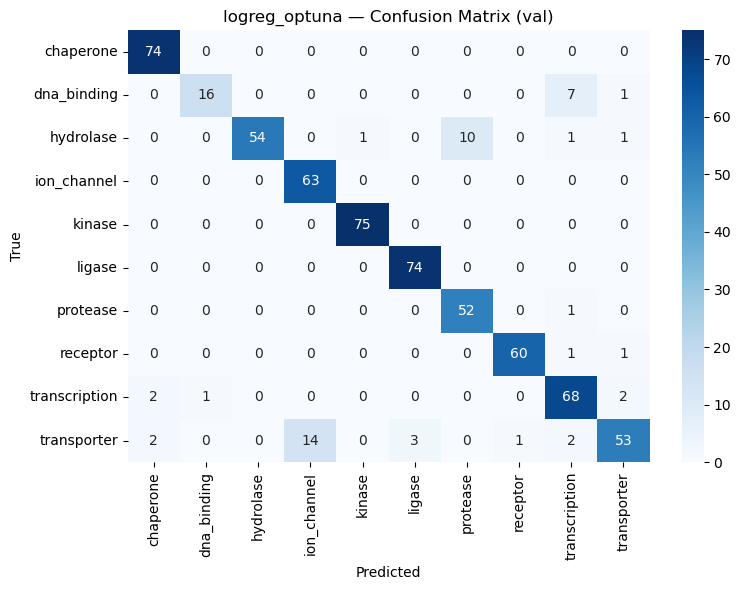

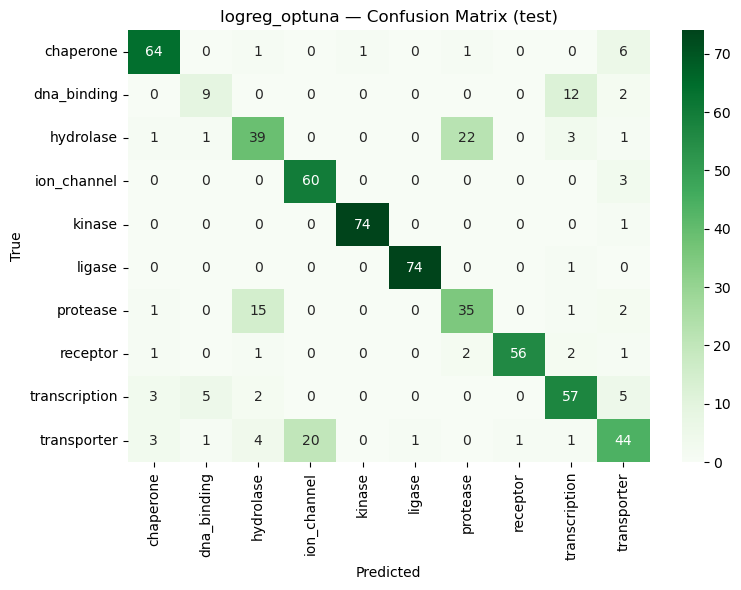


Saved model to: D:\ML\BioML\ESM\artifacts\models\logreg_optuna_esm1b.joblib

=== Logging to MLflow ===
MLflow run_id: b2de5617adac47409fedad5ca08a7b34

Чтобы открыть MLflow UI, запусти в терминале:
mlflow ui --backend-store-uri file:///D:/ML/BioML/ESM/logs/mlruns


In [7]:
# Cell 5: финальное обучение LogisticRegression с лучшими параметрами, вывод, сохранение, MLflow

# Объединяем train + val для финального обучения
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

best_params = study_logreg.best_params.copy()
print("Best params for final training:", best_params)

final_logreg = LogisticRegression(
    C=best_params["C"],
    penalty="l2",
    solver=best_params["solver"],
    max_iter=2000,
    n_jobs=-1,
    multi_class="multinomial",
)

print("\n=== Fitting final LogisticRegression on train+val ===")
final_logreg.fit(X_train_full, y_train_full)

print("=== Evaluating final model (using original train/val/test splits) ===")
metrics_logreg, fig_val_path, fig_test_path = evaluate_and_plot(
    model=final_logreg,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    le=le,
    figures_dir=FIGURES_DIR,
    model_name="logreg_optuna",
)

# Сохраняем модель на диск
logreg_model_path = MODELS_DIR / "logreg_optuna_esm1b.joblib"
dump(final_logreg, logreg_model_path)
print("\nSaved model to:", logreg_model_path)

# Логирование в MLflow
print("\n=== Logging to MLflow ===")
with mlflow.start_run(run_name="logreg_optuna_esm1b") as run:
    # параметры модели
    mlflow.log_params(best_params)
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("multi_class", "multinomial")
    mlflow.log_param("max_iter", 2000)
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("n_classes", len(le.classes_))

    # метрики
    for k, v in metrics_logreg.items():
        mlflow.log_metric(k, float(v))

    # артефакты
    mlflow.log_artifact(str(logreg_model_path), artifact_path="models")
    mlflow.log_artifact(str(fig_val_path), artifact_path="figures")
    mlflow.log_artifact(str(fig_test_path), artifact_path="figures")

    # текстовый отчёт по тесту
    report_path = FIGURES_DIR / "logreg_classification_report_test.txt"
    y_test_pred = final_logreg.predict(X_test)
    with open(report_path, "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_test_pred, target_names=le.classes_))
    mlflow.log_artifact(str(report_path), artifact_path="reports")

    run_id = run.info.run_id

print("MLflow run_id:", run_id)
print("\nЧтобы открыть MLflow UI, запусти в терминале:")
print(f"mlflow ui --backend-store-uri {MLFLOW_TRACKING_URI}")

In [8]:
# Cell 6: Optuna-оптимизация для RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

def create_rf(trial: optuna.Trial) -> RandomForestClassifier:
    # Пространство гиперпараметров для леса
    n_estimators = trial.suggest_int("n_estimators", 100, 600, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 40)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        class_weight=class_weight,
        n_jobs=-1,
        random_state=42,
    )
    return rf


def rf_objective(trial: optuna.Trial) -> float:
    model = create_rf(trial)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1_macro = f1_score(y_val, y_val_pred, average="macro")

    trial.set_user_attr("val_f1_macro", float(f1_macro))
    print(f"[RF Trial {trial.number}] val_f1_macro={f1_macro:.4f}")

    return f1_macro


N_TRIALS_RF = 40  

rf_sampler = optuna.samplers.TPESampler(seed=42)
study_rf = optuna.create_study(
    direction="maximize",
    study_name="rf_esm_protein_family",
    sampler=rf_sampler,
)

print("=== Starting Optuna study for RandomForest ===")
study_rf.optimize(
    rf_objective,
    n_trials=N_TRIALS_RF,
    show_progress_bar=True,
)

print("\n=== Optuna finished for RandomForest ===")
print("Best value (val f1_macro):", study_rf.best_value)
print("Best params:", study_rf.best_params)

[I 2025-12-06 13:37:02,700] A new study created in memory with name: rf_esm_protein_family


=== Starting Optuna study for RandomForest ===


  0%|          | 0/40 [00:00<?, ?it/s]

[RF Trial 0] val_f1_macro=0.6975
[I 2025-12-06 13:37:09,118] Trial 0 finished with value: 0.6975471987851505 and parameters: {'n_estimators': 300, 'max_depth': 39, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6975471987851505.
[RF Trial 1] val_f1_macro=0.6779
[I 2025-12-06 13:37:11,167] Trial 1 finished with value: 0.6779239384504159 and parameters: {'n_estimators': 100, 'max_depth': 39, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.6975471987851505.
[RF Trial 2] val_f1_macro=0.6618
[I 2025-12-06 13:37:13,261] Trial 2 finished with value: 0.6617916342993713 and parameters: {'n_estimators': 400, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False, 'class_weight': None}. Best is trial 0 with value: 0.6975471987851505.
[RF Trial 3] val

Best params for final RandomForest training: {'n_estimators': 400, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'class_weight': None}

=== Fitting final RandomForest on train+val ===
=== Evaluating final RandomForest (using original train/val/test splits) ===
=== Metrics ===
    train_accuracy: 1.0000
    train_f1_macro: 1.0000
      val_accuracy: 1.0000
      val_f1_macro: 1.0000
     test_accuracy: 0.7922
     test_f1_macro: 0.7396

=== Classification report (test) ===
               precision    recall  f1-score   support

    chaperone       0.86      0.88      0.87        73
  dna_binding       0.50      0.13      0.21        23
    hydrolase       0.56      0.60      0.58        67
  ion_channel       0.81      0.92      0.86        63
       kinase       0.96      0.97      0.97        75
       ligase       0.89      0.99      0.94        75
     protease       0.66      0.61      0.63        54
     receptor       

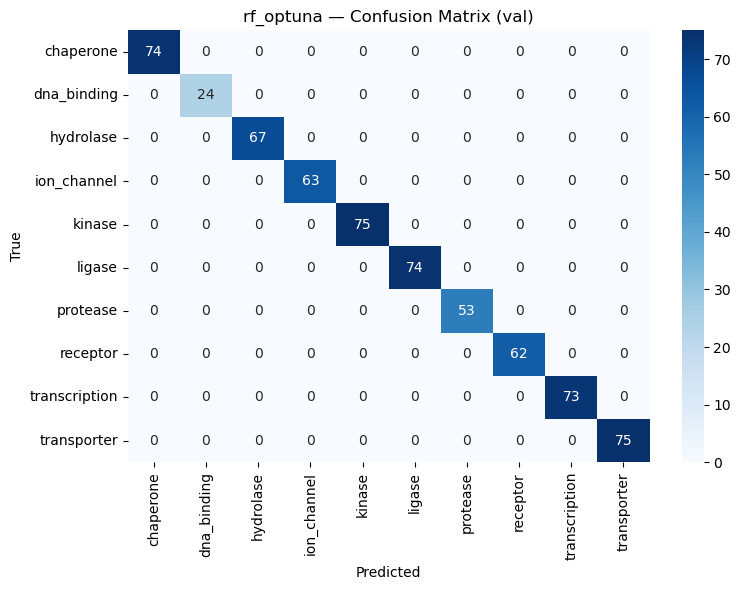

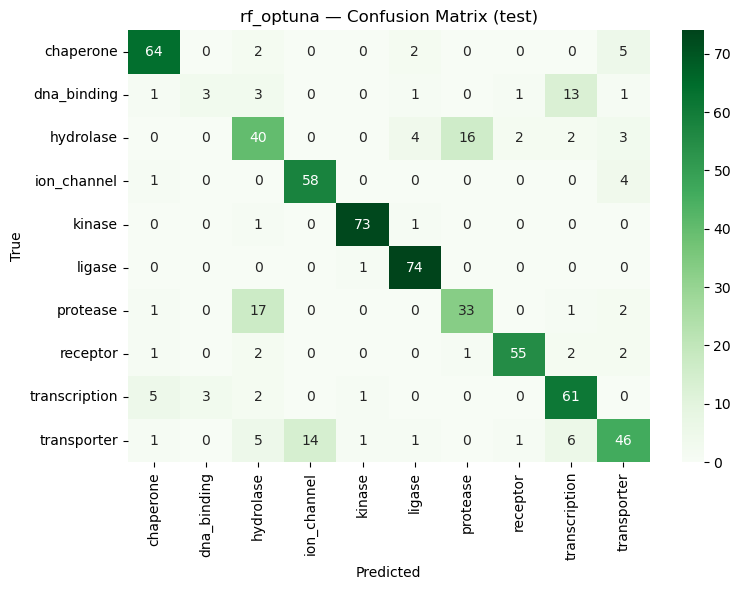


Saved RandomForest model to: D:\ML\BioML\ESM\artifacts\models\rf_optuna_esm1b.joblib

=== Logging RandomForest to MLflow ===
MLflow RF run_id: c696442b31394ba2b80654e8a774d781


In [9]:
# Cell 7: финальное обучение RandomForest с лучшими параметрами, вывод, сохранение, MLflow

# Объединяем train + val для финального обучения
X_train_full_rf = np.vstack([X_train, X_val])
y_train_full_rf = np.concatenate([y_train, y_val])

best_params_rf = study_rf.best_params.copy()
print("Best params for final RandomForest training:", best_params_rf)

final_rf = RandomForestClassifier(
    n_estimators=best_params_rf["n_estimators"],
    max_depth=best_params_rf["max_depth"],
    max_features=best_params_rf["max_features"],
    min_samples_split=best_params_rf["min_samples_split"],
    min_samples_leaf=best_params_rf["min_samples_leaf"],
    bootstrap=best_params_rf["bootstrap"],
    class_weight=best_params_rf["class_weight"],
    n_jobs=-1,
    random_state=42,
)

print("\n=== Fitting final RandomForest on train+val ===")
final_rf.fit(X_train_full_rf, y_train_full_rf)

print("=== Evaluating final RandomForest (using original train/val/test splits) ===")
metrics_rf, rf_fig_val_path, rf_fig_test_path = evaluate_and_plot(
    model=final_rf,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    le=le,
    figures_dir=FIGURES_DIR,
    model_name="rf_optuna",
)

# Сохраняем модель
rf_model_path = MODELS_DIR / "rf_optuna_esm1b.joblib"
dump(final_rf, rf_model_path)
print("\nSaved RandomForest model to:", rf_model_path)

# Логирование в MLflow
print("\n=== Logging RandomForest to MLflow ===")
with mlflow.start_run(run_name="rf_optuna_esm1b") as run:
    # параметры модели
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("n_classes", len(le.classes_))
    for k, v in best_params_rf.items():
        mlflow.log_param(k, v)

    # метрики
    for k, v in metrics_rf.items():
        mlflow.log_metric(k, float(v))

    # артефакты
    mlflow.log_artifact(str(rf_model_path), artifact_path="models")
    mlflow.log_artifact(str(rf_fig_val_path), artifact_path="figures")
    mlflow.log_artifact(str(rf_fig_test_path), artifact_path="figures")

    # текстовый отчёт по тесту
    rf_report_path = FIGURES_DIR / "rf_classification_report_test.txt"
    y_test_pred_rf = final_rf.predict(X_test)
    with open(rf_report_path, "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_test_pred_rf, target_names=le.classes_))
    mlflow.log_artifact(str(rf_report_path), artifact_path="reports")

    run_id_rf = run.info.run_id

print("MLflow RF run_id:", run_id_rf)

In [10]:
# Cell 8: Optuna-оптимизация для MLPClassifier (скрытый перцептрон)

# Игнорируем ворнинги про не сошедшуюся оптимизацию, чтобы не засоряли вывод
warnings.filterwarnings("ignore", category=ConvergenceWarning)


def create_mlp(trial: optuna.Trial) -> MLPClassifier:
    # 1 или 2 скрытых слоя
    n_hidden_layers = trial.suggest_categorical("n_hidden_layers", [1, 2])

    hidden_dim1 = trial.suggest_int("hidden_dim1", 128, 1024, step=128)
    if n_hidden_layers == 1:
        hidden_layer_sizes = (hidden_dim1,)
    else:
        hidden_dim2 = trial.suggest_int("hidden_dim2", 64, 512, step=64)
        hidden_layer_sizes = (hidden_dim1, hidden_dim2)

    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)  # L2-регуляризация
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation="relu",
        solver="adam",
        alpha=alpha,
        batch_size=batch_size,
        learning_rate_init=learning_rate_init,
        max_iter=200,           # относительно небольшой лимит, но с early_stopping
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,  # внутренний dev для остановки
        random_state=42,
    )

    return mlp


def mlp_objective(trial: optuna.Trial) -> float:
    model = create_mlp(trial)

    # обучаем на train
    model.fit(X_train, y_train)

    # оцениваем на нашей внешней валидации
    y_val_pred = model.predict(X_val)
    f1_macro = f1_score(y_val, y_val_pred, average="macro")

    trial.set_user_attr("val_f1_macro", float(f1_macro))
    print(f"[MLP Trial {trial.number}] val_f1_macro={f1_macro:.4f}")

    return f1_macro


N_TRIALS_MLP = 30  

mlp_sampler = optuna.samplers.TPESampler(seed=42)
study_mlp = optuna.create_study(
    direction="maximize",
    study_name="mlp_esm_protein_family",
    sampler=mlp_sampler,
)

print("=== Starting Optuna study for MLPClassifier ===")
study_mlp.optimize(
    mlp_objective,
    n_trials=N_TRIALS_MLP,
    show_progress_bar=True,
)

print("\n=== Optuna finished for MLP ===")
print("Best value (val f1_macro):", study_mlp.best_value)
print("Best params:", study_mlp.best_params)

[I 2025-12-06 13:50:35,687] A new study created in memory with name: mlp_esm_protein_family


=== Starting Optuna study for MLPClassifier ===


  0%|          | 0/30 [00:00<?, ?it/s]

[MLP Trial 0] val_f1_macro=0.7418
[I 2025-12-06 13:51:03,583] Trial 0 finished with value: 0.7417918483336189 and parameters: {'n_hidden_layers': 2, 'hidden_dim1': 768, 'hidden_dim2': 320, 'alpha': 4.207988669606632e-05, 'learning_rate_init': 0.00020511104188433984, 'batch_size': 128}. Best is trial 0 with value: 0.7417918483336189.
[MLP Trial 1] val_f1_macro=0.7152
[I 2025-12-06 13:51:13,158] Trial 1 finished with value: 0.7151661590303743 and parameters: {'n_hidden_layers': 1, 'hidden_dim1': 1024, 'alpha': 0.021368329072358756, 'learning_rate_init': 0.00026587543983272726, 'batch_size': 256}. Best is trial 0 with value: 0.7417918483336189.
[MLP Trial 2] val_f1_macro=0.7587
[I 2025-12-06 13:51:23,080] Trial 2 finished with value: 0.7586542245241055 and parameters: {'n_hidden_layers': 1, 'hidden_dim1': 384, 'alpha': 0.0028016351587162596, 'learning_rate_init': 0.00019010245319870352, 'batch_size': 256}. Best is trial 2 with value: 0.7586542245241055.
[MLP Trial 3] val_f1_macro=0.7587
[

Best params for final MLP training: {'n_hidden_layers': 2, 'hidden_dim1': 896, 'hidden_dim2': 128, 'alpha': 1.0521761868451132e-05, 'learning_rate_init': 0.004274869455295219, 'batch_size': 256}

=== Fitting final MLP on train+val ===
=== Evaluating final MLP (using original train/val/test splits) ===
=== Metrics ===
    train_accuracy: 0.9166
    train_f1_macro: 0.9028
      val_accuracy: 0.9141
      val_f1_macro: 0.9014
     test_accuracy: 0.7937
     test_f1_macro: 0.7667

=== Classification report (test) ===
               precision    recall  f1-score   support

    chaperone       0.89      0.89      0.89        73
  dna_binding       0.53      0.43      0.48        23
    hydrolase       0.62      0.60      0.61        67
  ion_channel       0.75      0.92      0.83        63
       kinase       0.99      0.97      0.98        75
       ligase       0.97      0.99      0.98        75
     protease       0.60      0.65      0.62        54
     receptor       0.98      0.86      

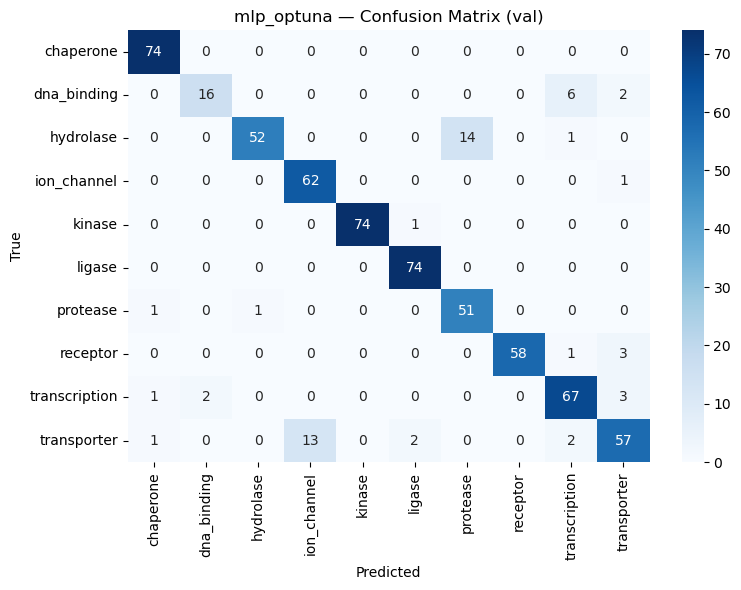

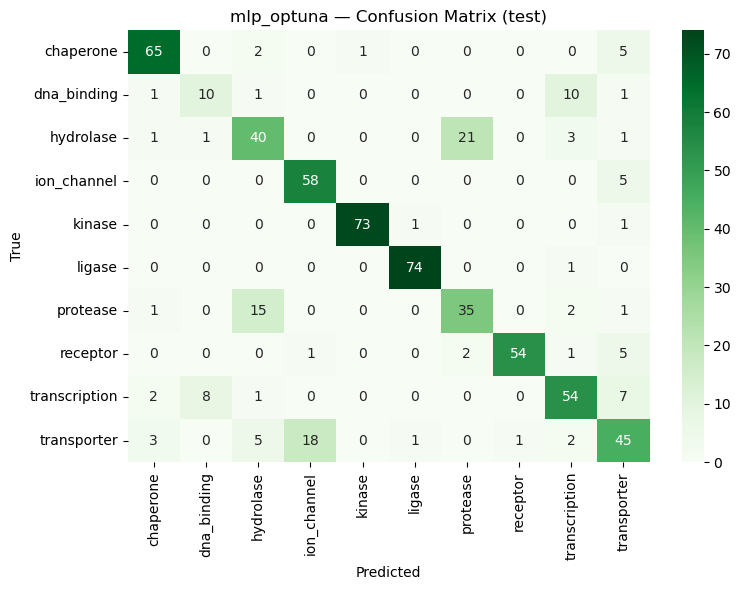


Saved MLP model to: D:\ML\BioML\ESM\artifacts\models\mlp_optuna_esm1b.joblib

=== Logging MLP to MLflow ===
MLflow MLP run_id: ef0adcc428a8442cb214b3123cc941c5


In [11]:
# Cell 9: финальное обучение MLP с лучшими параметрами, вывод, сохранение, MLflow

# Объединяем train + val для финального обучения
X_train_full_mlp = np.vstack([X_train, X_val])
y_train_full_mlp = np.concatenate([y_train, y_val])

best_params_mlp = study_mlp.best_params.copy()
print("Best params for final MLP training:", best_params_mlp)

# Восстанавливаем структуру hidden_layer_sizes
if best_params_mlp["n_hidden_layers"] == 1:
    hidden_layer_sizes = (best_params_mlp["hidden_dim1"],)
else:
    hidden_layer_sizes = (
        best_params_mlp["hidden_dim1"],
        best_params_mlp["hidden_dim2"],
    )

final_mlp = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    activation="relu",
    solver="adam",
    alpha=best_params_mlp["alpha"],
    batch_size=best_params_mlp["batch_size"],
    learning_rate_init=best_params_mlp["learning_rate_init"],
    max_iter=300,           
    early_stopping=True,
    n_iter_no_change=15,
    validation_fraction=0.1,
    random_state=42,
)

print("\n=== Fitting final MLP on train+val ===")
final_mlp.fit(X_train_full_mlp, y_train_full_mlp)

print("=== Evaluating final MLP (using original train/val/test splits) ===")
metrics_mlp, mlp_fig_val_path, mlp_fig_test_path = evaluate_and_plot(
    model=final_mlp,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    le=le,
    figures_dir=FIGURES_DIR,
    model_name="mlp_optuna",
)

# Сохраняем модель
mlp_model_path = MODELS_DIR / "mlp_optuna_esm1b.joblib"
dump(final_mlp, mlp_model_path)
print("\nSaved MLP model to:", mlp_model_path)

# Логирование в MLflow
print("\n=== Logging MLP to MLflow ===")
with mlflow.start_run(run_name="mlp_optuna_esm1b") as run:
    # параметры модели
    mlflow.log_param("model_type", "MLPClassifier")
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("n_classes", len(le.classes_))
    mlflow.log_param("hidden_layer_sizes", hidden_layer_sizes)

    # логируем гиперы из Optuna
    for k, v in best_params_mlp.items():
        mlflow.log_param(k, v)

    # метрики
    for k, v in metrics_mlp.items():
        mlflow.log_metric(k, float(v))

    # артефакты
    mlflow.log_artifact(str(mlp_model_path), artifact_path="models")
    mlflow.log_artifact(str(mlp_fig_val_path), artifact_path="figures")
    mlflow.log_artifact(str(mlp_fig_test_path), artifact_path="figures")

    # текстовый отчёт по тесту
    mlp_report_path = FIGURES_DIR / "mlp_classification_report_test.txt"
    y_test_pred_mlp = final_mlp.predict(X_test)
    with open(mlp_report_path, "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_test_pred_mlp, target_names=le.classes_))
    mlflow.log_artifact(str(mlp_report_path), artifact_path="reports")

    run_id_mlp = run.info.run_id

print("MLflow MLP run_id:", run_id_mlp)


In [13]:
# Cell 10: Optuna-оптимизация для CatBoostClassifier

USE_GPU = False

def create_catboost(trial: optuna.Trial) -> CatBoostClassifier:
    depth = trial.suggest_int("depth", 4, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 20.0, log=True)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0.0, 1.0)
    rsm = trial.suggest_float("rsm", 0.5, 1.0)
    random_strength = trial.suggest_float("random_strength", 0.0, 20.0)
    iterations = trial.suggest_int("iterations", 300, 1200, step=100)

    params = dict(
        loss_function="MultiClass",
        eval_metric="TotalF1",   # для внутреннего мониторинга
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        rsm=rsm,
        random_strength=random_strength,
        iterations=iterations,
        od_type="Iter",
        od_wait=50,
        random_seed=42,
        verbose=False,
    )

    if USE_GPU:
        params.update(
            dict(
                task_type="GPU",
                devices="0",
            )
        )

    model = CatBoostClassifier(**params)
    return model


def catboost_objective(trial: optuna.Trial) -> float:
    model = create_catboost(trial)

    # Обучаем на train, валимся на X_val/y_val
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

    # Предсказания и F1_macro на нашей валидации
    y_val_pred = model.predict(X_val)
    # CatBoost выдаёт shape (n, 1), приводим к 1D
    y_val_pred = y_val_pred.reshape(-1).astype(int)

    f1_macro = f1_score(y_val, y_val_pred, average="macro")

    trial.set_user_attr("val_f1_macro", float(f1_macro))
    print(f"[CatBoost Trial {trial.number}] val_f1_macro={f1_macro:.4f}")

    return f1_macro


N_TRIALS_CAT = 40 

cat_sampler = optuna.samplers.TPESampler(seed=42)
study_cat = optuna.create_study(
    direction="maximize",
    study_name="catboost_esm_protein_family",
    sampler=cat_sampler,
)

print("=== Starting Optuna study for CatBoost ===")
study_cat.optimize(
    catboost_objective,
    n_trials=N_TRIALS_CAT,
    show_progress_bar=True,
)

print("\n=== Optuna finished for CatBoost ===")
print("Best value (val f1_macro):", study_cat.best_value)
print("Best params:", study_cat.best_params)

[I 2025-12-06 14:16:41,743] A new study created in memory with name: catboost_esm_protein_family


=== Starting Optuna study for CatBoost ===


  0%|          | 0/40 [00:00<?, ?it/s]

[CatBoost Trial 0] val_f1_macro=0.7147
[I 2025-12-06 14:18:46,414] Trial 0 finished with value: 0.7146860284442961 and parameters: {'depth': 5, 'learning_rate': 0.2536999076681772, 'l2_leaf_reg': 8.960785365368121, 'bagging_temperature': 0.5986584841970366, 'rsm': 0.5780093202212182, 'random_strength': 3.119890406724053, 'iterations': 300}. Best is trial 0 with value: 0.7146860284442961.
[CatBoost Trial 1] val_f1_macro=0.6892
[I 2025-12-06 15:01:52,344] Trial 1 finished with value: 0.6892383791918675 and parameters: {'depth': 8, 'learning_rate': 0.07725378389307355, 'l2_leaf_reg': 8.341106432362084, 'bagging_temperature': 0.020584494295802447, 'rsm': 0.9849549260809971, 'random_strength': 16.648852816008436, 'iterations': 500}. Best is trial 0 with value: 0.7146860284442961.
[CatBoost Trial 2] val_f1_macro=0.6785
[I 2025-12-06 15:05:39,153] Trial 2 finished with value: 0.678487612611195 and parameters: {'depth': 4, 'learning_rate': 0.018659959624904916, 'l2_leaf_reg': 2.487873441981442

Best params for final CatBoost training: {'depth': 5, 'learning_rate': 0.19320711938412277, 'l2_leaf_reg': 1.6541235386035178, 'bagging_temperature': 0.29917321269989444, 'rsm': 0.5519863753750097, 'random_strength': 12.85694861181111, 'iterations': 900}

=== Fitting final CatBoost on train+val ===
=== Evaluating final CatBoost (using original train/val/test splits) ===
=== Metrics ===
    train_accuracy: 0.9993
    train_f1_macro: 0.9993
      val_accuracy: 1.0000
      val_f1_macro: 1.0000
     test_accuracy: 0.7812
     test_f1_macro: 0.7253

=== Classification report (test) ===
               precision    recall  f1-score   support

    chaperone       0.84      0.86      0.85        73
  dna_binding       0.25      0.09      0.13        23
    hydrolase       0.61      0.55      0.58        67
  ion_channel       0.82      0.92      0.87        63
       kinase       0.91      0.97      0.94        75
       ligase       0.95      0.95      0.95        75
     protease       0.63 

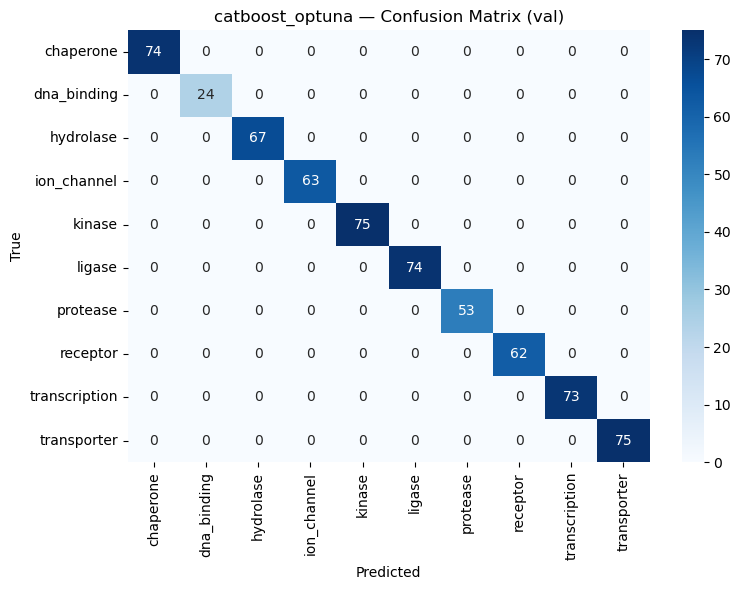

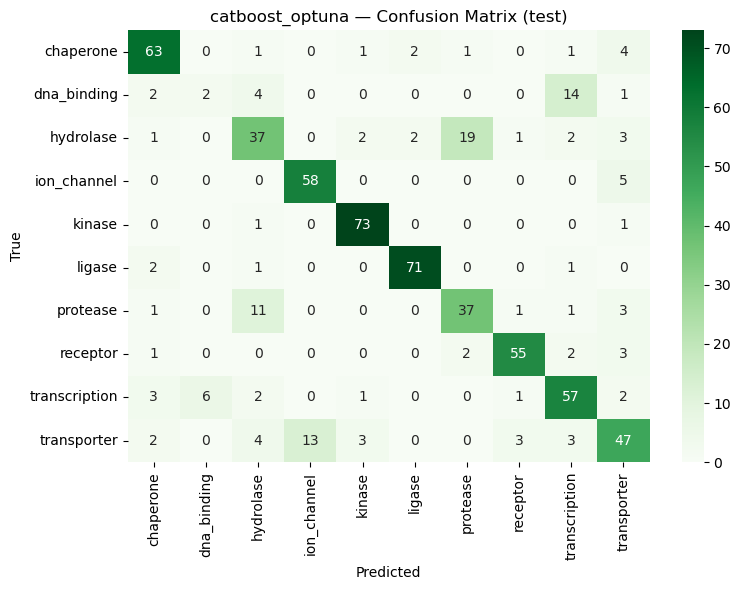


Saved CatBoost model to: D:\ML\BioML\ESM\artifacts\models\catboost_optuna_esm1b.cbm

=== Logging CatBoost to MLflow ===
MLflow CatBoost run_id: 9c0e465f3cd843baa9e3cd1641f93db3


In [14]:
# Cell 11: финальное обучение CatBoost с лучшими параметрами, вывод, сохранение, MLflow

# Объединяем train + val для финального обучения
X_train_full_cat = np.vstack([X_train, X_val])
y_train_full_cat = np.concatenate([y_train, y_val])

best_params_cat = study_cat.best_params.copy()
print("Best params for final CatBoost training:", best_params_cat)

# Собираем параметры модели
cat_params = dict(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    depth=int(best_params_cat["depth"]),
    learning_rate=best_params_cat["learning_rate"],
    l2_leaf_reg=best_params_cat["l2_leaf_reg"],
    bagging_temperature=best_params_cat["bagging_temperature"],
    rsm=best_params_cat["rsm"],
    random_strength=best_params_cat["random_strength"],
    iterations=int(best_params_cat["iterations"]),
    od_type="Iter",
    od_wait=50,
    random_seed=42,
    verbose=False,
)

if USE_GPU:
    cat_params.update(
        dict(
            task_type="GPU",
            devices="0",
        )
    )

final_cat = CatBoostClassifier(**cat_params)

print("\n=== Fitting final CatBoost on train+val ===")
final_cat.fit(X_train_full_cat, y_train_full_cat, eval_set=(X_val, y_val), use_best_model=True)

print("=== Evaluating final CatBoost (using original train/val/test splits) ===")
# evaluate_and_plot ожидает, что model.predict вернёт 1D-массив меток
def _cat_predict_wrapper(model, X):
    y_pred = model.predict(X)
    return y_pred.reshape(-1).astype(int)

# Переопределим временно метод predict у объекта для совместимости
class CatBoostWrapper:
    def __init__(self, cb_model):
        self.cb_model = cb_model

    def predict(self, X):
        y_pred = self.cb_model.predict(X)
        return y_pred.reshape(-1).astype(int)

wrapped_cat = CatBoostWrapper(final_cat)

metrics_cat, cat_fig_val_path, cat_fig_test_path = evaluate_and_plot(
    model=wrapped_cat,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    le=le,
    figures_dir=FIGURES_DIR,
    model_name="catboost_optuna",
)

# Сохраняем модель
cat_model_path = MODELS_DIR / "catboost_optuna_esm1b.cbm"
final_cat.save_model(cat_model_path)
print("\nSaved CatBoost model to:", cat_model_path)

# Логирование в MLflow
print("\n=== Logging CatBoost to MLflow ===")
with mlflow.start_run(run_name="catboost_optuna_esm1b") as run:
    # параметры модели
    mlflow.log_param("model_type", "CatBoostClassifier")
    mlflow.log_param("n_features", X.shape[1])
    mlflow.log_param("n_classes", len(le.classes_))
    mlflow.log_param("task_type", "GPU" if USE_GPU else "CPU")

    for k, v in best_params_cat.items():
        mlflow.log_param(k, v)

    # метрики
    for k, v in metrics_cat.items():
        mlflow.log_metric(k, float(v))

    # артефакты
    mlflow.log_artifact(str(cat_model_path), artifact_path="models")
    mlflow.log_artifact(str(cat_fig_val_path), artifact_path="figures")
    mlflow.log_artifact(str(cat_fig_test_path), artifact_path="figures")

    # текстовый отчёт по тесту
    cat_report_path = FIGURES_DIR / "catboost_classification_report_test.txt"
    y_test_pred_cat = wrapped_cat.predict(X_test)
    with open(cat_report_path, "w", encoding="utf-8") as f:
        f.write(classification_report(y_test, y_test_pred_cat, target_names=le.classes_))
    mlflow.log_artifact(str(cat_report_path), artifact_path="reports")

    run_id_cat = run.info.run_id

print("MLflow CatBoost run_id:", run_id_cat)

In [15]:
import pandas as pd

results = []

results.append({"model": "LogisticRegression", **metrics_logreg})
results.append({"model": "RandomForest", **metrics_rf})
results.append({"model": "MLP", **metrics_mlp})
results.append({"model": "CatBoost", **metrics_cat})

results_df = pd.DataFrame(results)
results_df

,model,train_accuracy,train_f1_macro,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
0,LogisticRegression,0.937332,0.926232,0.920312,0.908608,0.800000,0.769644
1,RandomForest,1.000000,1.000000,1.000000,1.000000,0.792188,0.739603
2,MLP,0.916555,0.902752,0.914062,0.901359,0.793750,0.766738
3,CatBoost,0.999330,0.999325,1.000000,1.000000,0.781250,0.725262


## 1. Итоговый анализ моделей
Модель	Test F1 Macro	Характер

LogisticRegression	0.7696	лучший generalization, сильный baseline

MLP	0.7667	почти равен логрегу, чуть менее стабилен

RandomForest	0.7396	переобучился, но стабильный «средний»

CatBoost	0.7253	переобучился сильнее всех

## 2. Ключевые выводы 

Лучшая модель по обобщающей способности — Logistic Regression.

Простой линейный классификатор на топовых эмбеддингах ESM-1b даёт наилучший test F1 (≈0.77).

MLP показывает сопоставимое качество, но не превосходит логрег.

RandomForest и CatBoost сильно переобучаются, о чём говорит разрыв между train/val и test.

Это подчёркивает важный научный вывод:

заранее обученные белковые эмбеддинги содержат достаточную линейно разделимую структуру,
и сложные модели дают преимущественно переобучение, а не улучшение качества.

Решение

В качестве финальной модели проекта выбрана:

→ Logistic Regression (best generalization)